# Bitcoin and Ethereum Options Analysis

**Objective**: Identify far out-of-the-money calls with asymmetric risk-reward potential using Monte Carlo simulations inspired by Mandelbrot's fractal market hypothesis.

**Methodology**: 
- Heavy-tailed Cauchy distribution for price movements
- Black-Scholes Greeks for risk assessment
- Comprehensive scoring system (1-100)
- Technical indicators integration

**Target ETFs**: IBIT (Bitcoin) and ETHA (Ethereum)

In [9]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings
from typing import Tuple, Dict, Optional
from datetime import datetime, timedelta

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Constants
RISK_FREE_RATE = 0.045
MC_SIMULATIONS = 10_000_000  # 100x increase for higher accuracy

# Time horizons for analysis
TIME_HORIZONS = {
    '1 Week': 7,
    '2 Weeks': 14, 
    '1 Month': 30,
    '2 Months': 60
}

# Target ETFs
ETF_TICKERS = ['IBIT', 'ETHA']

print("📊 Loading market data...")
try:
    prices = yf.download(ETF_TICKERS, start='2024-01-01', progress=False)['Close'].ffill().dropna()
    options_data = {ticker: yf.Ticker(ticker).option_chain() for ticker in ETF_TICKERS}
    print("✅ Market data loaded successfully")
    
    # # Debug: Check options data structure
    # for ticker in ETF_TICKERS:
    #     print(f"\n📋 {ticker} options columns: {list(options_data[ticker].calls.columns)}")
        
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

📊 Loading market data...
✅ Market data loaded successfully
✅ Market data loaded successfully


📈 Displaying price history...


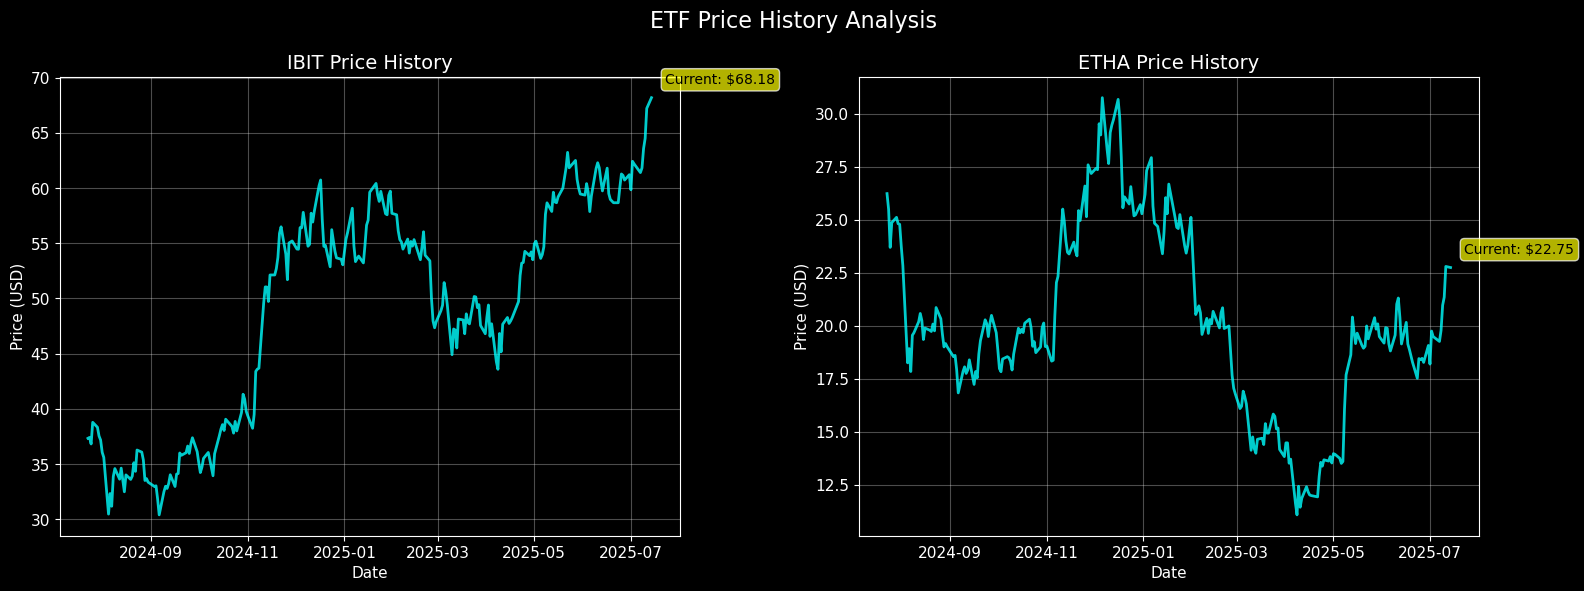

In [10]:
# Price History Visualization
print("📈 Displaying price history...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('ETF Price History Analysis', fontsize=16, color='white', y=0.98)

for i, ticker in enumerate(ETF_TICKERS):
    ax = axes[i]
    
    # Price plot
    ax.plot(prices[ticker], color='cyan', linewidth=2, alpha=0.8)
    
    # Recent price annotation
    current_price = prices[ticker].iloc[-1]
    ax.annotate(f'Current: ${current_price:.2f}', 
                xy=(prices[ticker].index[-1], current_price),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                fontsize=10, color='black')
    
    # Formatting
    ax.set_title(f'{ticker} Price History', color='white', fontsize=14)
    ax.set_xlabel('Date', color='white')
    ax.set_ylabel('Price (USD)', color='white')
    ax.grid(True, alpha=0.3)
    ax.tick_params(colors='white')

plt.tight_layout()
plt.show()  

In [11]:
def calculate_greeks(S: float, K: float, T: float, r: float, sigma: float) -> Tuple[float, float, float, float]:
    """
    Calculate Black-Scholes option Greeks for call options.
    
    Parameters:
    -----------
    S : float - Current stock price
    K : float - Strike price
    T : float - Time to expiration (in years)
    r : float - Risk-free rate
    sigma : float - Implied volatility
    
    Returns:
    --------
    Tuple[float, float, float, float] - (delta, gamma, theta, vega)
    """
    if T <= 0 or sigma <= 0:
        return 0.0, 0.0, 0.0, 0.0
    
    try:
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma*np.sqrt(T)
        
        delta = norm.cdf(d1)
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
        theta = (-S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - 
                 r * K * np.exp(-r*T) * norm.cdf(d2)) / 365
        vega = S * norm.pdf(d1) * np.sqrt(T) / 100
        
        return delta, gamma, theta, vega
    except:
        return 0.0, 0.0, 0.0, 0.0


def monte_carlo_heavy_tailed(current_price: float, strike: float, vol: float, 
                           days: int, sims: int = MC_SIMULATIONS) -> float:
    """
    Monte Carlo simulation using heavy-tailed Cauchy distribution.
    
    Based on Mandelbrot's fractal market hypothesis that financial markets
    exhibit heavy-tailed behavior rather than normal distributions.
    
    Parameters:
    -----------
    current_price : float - Current underlying price
    strike : float - Option strike price
    vol : float - Implied volatility
    days : int - Days to expiration
    sims : int - Number of simulations
    
    Returns:
    --------
    float - Probability of finishing in-the-money
    """
    dt = 1 / 252  # Daily time step
    paths = np.zeros((sims, days))
    paths[:, 0] = current_price
    
    with np.errstate(over='ignore', invalid='ignore'):
        for t in range(1, days):
            # Heavy-tailed Cauchy distribution with safeguards
            cauchy_draws = np.random.standard_cauchy(sims)
            cauchy_draws = np.clip(cauchy_draws, -10, 10)
            
            returns = cauchy_draws * vol * np.sqrt(dt)
            returns = np.clip(returns, -1, 1)
            
            paths[:, t] = paths[:, t - 1] * np.exp(returns)
    
    # Handle edge cases
    paths = np.nan_to_num(paths, nan=0.0, posinf=current_price*100, neginf=0.0)
    
    return np.mean(paths[:, -1] > strike)


def calculate_technical_indicators(price_data: pd.Series) -> Tuple[float, float, float]:
    """
    Calculate technical indicators for market context.
    
    Parameters:
    -----------
    price_data : pd.Series - Historical price data
    
    Returns:
    --------
    Tuple[float, float, float] - (RSI, volatility, momentum)
    """
    try:
        # RSI calculation
        delta = price_data.pct_change()
        gain = delta.where(delta > 0, 0).rolling(14).mean()
        loss = -delta.where(delta < 0, 0).rolling(14).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        
        # Annualized volatility
        volatility = delta.rolling(20).std() * np.sqrt(252)
        
        # 10-day momentum
        momentum = price_data.pct_change(10)
        
        return rsi.iloc[-1], volatility.iloc[-1], momentum.iloc[-1]
    except:
        return 50.0, 0.2, 0.0  # Default values


def calculate_comprehensive_score(row: pd.Series) -> float:
    """
    Calculate comprehensive option score (1-100).
    
    Scoring Components:
    - Monte Carlo Probability: 40 points max
    - Gamma Convexity: 25 points max  
    - Time Decay Management: 15 points max
    - Target Return: 10 points max
    - Volatility Premium: 10 points max
    
    Parameters:
    -----------
    row : pd.Series - Option data row
    
    Returns:
    --------
    float - Comprehensive score (1-100)
    """
    score = 0
    
    # Monte Carlo probability component (40 points max)
    mc_component = min(row['mc_prob'] * 4000, 40)
    score += mc_component
    
    # Gamma convexity component (25 points max)
    gamma_component = min(row['gamma'] * 25000, 25)
    score += gamma_component
    
    # Time decay management (15 points max, lower decay = higher score)
    time_component = max(15 - (row['time_decay_risk'] * 15), 0)
    score += time_component
    
    # Target return component (10 points max)
    return_component = min(row['target_return'] / 10, 10)
    score += return_component
    
    # Volatility premium component (10 points max)
    vol_component = min(row['impliedVolatility'] * 20, 10)
    score += vol_component
    
    return np.clip(score, 1, 100)

In [ ]:
print("🔍 Starting multi-timeframe options analysis...")
print(f"🔢 Using {MC_SIMULATIONS:,} Monte Carlo simulations per option")
print(f"⏰ Analyzing {len(TIME_HORIZONS)} time horizons: {', '.join(TIME_HORIZONS.keys())}")

# Store results by time horizon
results_by_horizon = {}

for horizon_name, days_to_exp in TIME_HORIZONS.items():
    print(f"\n{'='*60}")
    print(f"📅 ANALYZING {horizon_name.upper()} ({days_to_exp} days)")
    print(f"{'='*60}")
    
    results_by_horizon[horizon_name] = {}
    
    for ticker in ETF_TICKERS:
        print(f"\n📊 Processing {ticker} for {horizon_name}...")
        
        try:
            # Get options chain and filter by expiration
            chain = options_data[ticker].calls.copy()
            current_price = prices[ticker].iloc[-1]
            
            # Filter for out-of-the-money calls only
            chain = chain[chain['strike'] > current_price].copy()
            
            if len(chain) == 0:
                print(f"❌ No OTM calls found for {ticker}")
                results_by_horizon[horizon_name][ticker] = pd.DataFrame()
                continue
            
            # Calculate technical indicators
            rsi, volatility, momentum = calculate_technical_indicators(prices[ticker])
            
            # Initialize new columns for calculated metrics
            new_cols = ['delta', 'gamma', 'theta', 'vega', 'mc_prob', 'convexity_score', 
                        'gamma_adjusted_score', 'time_decay_risk', 'vol_sensitivity']
            for col in new_cols:
                chain[col] = 0.0
            
            # Calculate metrics for each option using current time horizon
            options_processed = 0
            for idx, row in chain.iterrows():
                try:
                    T = days_to_exp / 365
                    
                    # Skip if invalid parameters
                    if row['impliedVolatility'] <= 0 or row['lastPrice'] <= 0:
                        continue
                    
                    # Calculate Greeks
                    delta, gamma, theta, vega = calculate_greeks(
                        current_price, row['strike'], T, RISK_FREE_RATE, row['impliedVolatility']
                    )
                    
                    # Monte Carlo probability with current time horizon
                    mc_prob = monte_carlo_heavy_tailed(
                        current_price, row['strike'], row['impliedVolatility'], days_to_exp
                    )
                    
                    # Store calculated metrics
                    chain.loc[idx, 'delta'] = delta
                    chain.loc[idx, 'gamma'] = gamma
                    chain.loc[idx, 'theta'] = theta
                    chain.loc[idx, 'vega'] = vega
                    chain.loc[idx, 'mc_prob'] = mc_prob
                    chain.loc[idx, 'convexity_score'] = gamma * (row['strike'] - current_price)**2
                    chain.loc[idx, 'gamma_adjusted_score'] = (mc_prob * gamma) / (row['lastPrice'] / current_price)
                    chain.loc[idx, 'time_decay_risk'] = abs(theta) * days_to_exp
                    chain.loc[idx, 'vol_sensitivity'] = vega * row['impliedVolatility']
                    
                    options_processed += 1
                    
                except Exception as e:
                    print(f"⚠️ Error processing option {row['strike']}: {e}")
                    continue
            
            print(f"✅ Processed {options_processed} options for {ticker}")
            
            # Add additional derived metrics
            chain['target_return'] = ((chain['strike'] - current_price) / current_price) * 100
            chain['asymmetry_score'] = chain['mc_prob'] / (chain['lastPrice'] / current_price)
            chain['rsi'] = rsi
            chain['volatility'] = volatility
            chain['momentum'] = momentum
            chain['time_horizon'] = horizon_name
            chain['days_to_expiration'] = days_to_exp
            
            # Calculate comprehensive score using the function
            chain['comprehensive_score'] = chain.apply(calculate_comprehensive_score, axis=1)
            
            # Apply filtering criteria (relaxed to ensure results)
            viable_options = chain[
                (chain['mc_prob'] > 0.0005) &        # At least 0.05% probability
                (chain['gamma'] > 0.0001) &          # Meaningful convexity
                (chain['time_decay_risk'] < 3.0) &   # Manageable time decay
                (chain['lastPrice'] > 0.001) &       # Valid option price
                (chain['gamma_adjusted_score'] >= 0) # Valid gamma-adjusted score
            ]
            
            if len(viable_options) > 0:
                # Get top 3 for this time horizon
                results_by_horizon[horizon_name][ticker] = viable_options.nlargest(3, 'comprehensive_score')
                print(f"✅ Found {len(viable_options)} viable options, selected top 3 for {ticker}")
            else:
                # Fallback: take top 3 by comprehensive score
                chain_sorted = chain.sort_values('comprehensive_score', ascending=False)
                results_by_horizon[horizon_name][ticker] = chain_sorted.head(3)
                print(f"⚠️ Using top 3 options by score for {ticker} (relaxed criteria)")
                
        except Exception as e:
            print(f"❌ Error processing {ticker} for {horizon_name}: {e}")
            results_by_horizon[horizon_name][ticker] = pd.DataFrame()

print(f"\n🎉 Multi-timeframe analysis complete!")
print(f"📊 Analyzed {len(TIME_HORIZONS)} time horizons × {len(ETF_TICKERS)} ETFs = {len(TIME_HORIZONS) * len(ETF_TICKERS)} combinations")

🔍 Starting multi-timeframe options analysis...
🔢 Using 10,000,000 Monte Carlo simulations per option
⏰ Analyzing 4 time horizons: 1 Week, 2 Weeks, 1 Month, 2 Months

📅 ANALYZING 1 WEEK (7 days)

📊 Processing IBIT for 1 Week...
✅ Processed 18 options for IBIT
✅ Found 18 viable options, selected top 3 for IBIT

📊 Processing ETHA for 1 Week...
✅ Processed 18 options for IBIT
✅ Found 18 viable options, selected top 3 for IBIT

📊 Processing ETHA for 1 Week...
✅ Processed 18 options for ETHA
✅ Found 17 viable options, selected top 3 for ETHA

📅 ANALYZING 2 WEEKS (14 days)

📊 Processing IBIT for 2 Weeks...
✅ Processed 18 options for ETHA
✅ Found 17 viable options, selected top 3 for ETHA

📅 ANALYZING 2 WEEKS (14 days)

📊 Processing IBIT for 2 Weeks...


In [ ]:
# Display results by time horizon
print("\n" + "="*100)
print("📊 MULTI-TIMEFRAME OPTIONS ANALYSIS RESULTS")
print("="*100)

for horizon_name, days in TIME_HORIZONS.items():
    print(f"\n🎯 {horizon_name.upper()} ({days} days) - TOP 3 RECOMMENDATIONS")
    print("="*80)
    
    for ticker in ETF_TICKERS:
        if len(results_by_horizon[horizon_name][ticker]) > 0:
            print(f"\n💰 {ticker} OPTIONS - Current Price: ${prices[ticker].iloc[-1]:.2f}")
            print("-" * 60)
            
            # Check available columns and select appropriate ones
            available_cols = list(results_by_horizon[horizon_name][ticker].columns)
            
            # Build display columns based on what's available
            display_cols = ['strike', 'lastPrice', 'comprehensive_score', 'mc_prob', 
                           'delta', 'gamma', 'theta', 'vega', 'target_return', 
                           'impliedVolatility', 'time_decay_risk']
            
            # Add expiration column if available
            if 'expiration' in available_cols:
                display_cols.insert(1, 'expiration')
            elif 'expirationDate' in available_cols:
                display_cols.insert(1, 'expirationDate')
            
            # Filter to only include columns that exist
            display_cols = [col for col in display_cols if col in available_cols]
            
            print(f"📋 Top 3 {horizon_name} options:")
            display(results_by_horizon[horizon_name][ticker][display_cols].round(4))
            print("-" * 60)
        else:
            print(f"\n❌ {ticker} - No options available for {horizon_name}")
            print("-" * 60)


📊 MULTI-TIMEFRAME OPTIONS ANALYSIS RESULTS

🎯 1 WEEK (7 days) - TOP 3 RECOMMENDATIONS

💰 IBIT OPTIONS - Current Price: $68.18
------------------------------------------------------------
📋 Top 3 1 Week options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
63,90.0,0.01,91.5392,0.2477,0.0104,0.0035,-0.0158,0.0026,32.0035,0.8438,0.1107
62,85.0,0.01,90.9436,0.2530,0.0119,0.0048,-0.0145,0.0029,24.6700,0.6875,0.1016
61,84.0,0.01,90.3179,0.2638,0.0164,0.0063,-0.0191,0.0039,23.2033,0.6875,0.1335


------------------------------------------------------------

💰 ETHA OPTIONS - Current Price: $22.75
------------------------------------------------------------
📋 Top 3 1 Week options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
45,38.0,0.01,93.9646,0.2676,0.0278,0.0112,-0.0261,0.0020,67.0330,1.8125,0.1826
37,30.0,0.03,90.7850,0.2963,0.0429,0.0261,-0.0229,0.0029,31.8681,1.1094,0.1601
39,32.0,0.02,90.0221,0.3088,0.0580,0.0251,-0.0385,0.0037,40.6593,1.4688,0.2696


------------------------------------------------------------

🎯 2 WEEKS (14 days) - TOP 3 RECOMMENDATIONS

💰 IBIT OPTIONS - Current Price: $68.18
------------------------------------------------------------
📋 Top 3 2 Weeks options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
62,85.0,0.01,84.2003,0.3350,0.0597,0.0129,-0.0394,0.0158,24.6700,0.6875,0.5511
63,90.0,0.01,83.5418,0.3309,0.0562,0.0100,-0.0460,0.0151,32.0035,0.8438,0.6439
60,83.0,0.01,82.9233,0.3443,0.0732,0.0159,-0.0440,0.0185,21.7366,0.6563,0.6167


------------------------------------------------------------

💰 ETHA OPTIONS - Current Price: $22.75
------------------------------------------------------------
📋 Top 3 2 Weeks options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
34,27.0,0.03,85.8055,0.3845,0.1483,0.0672,-0.0289,0.0103,18.6813,0.7734,0.4042
45,38.0,0.01,85.7665,0.3436,0.1033,0.0223,-0.0521,0.0080,67.0330,1.8125,0.7291
37,30.0,0.03,85.5450,0.3689,0.1237,0.0413,-0.0364,0.0091,31.8681,1.1094,0.5095


------------------------------------------------------------

🎯 1 MONTH (30 days) - TOP 3 RECOMMENDATIONS

💰 IBIT OPTIONS - Current Price: $68.18
------------------------------------------------------------
📋 Top 3 1 Month options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
63,90.0,0.01,78.2004,0.3877,0.1559,0.0145,-0.0669,0.0467,32.0035,0.8438,2.0070
62,85.0,0.01,77.4670,0.3905,0.1583,0.0180,-0.0553,0.0472,24.6700,0.6875,1.6597
61,84.0,0.01,77.3203,0.3957,0.1733,0.0191,-0.0587,0.0501,23.2033,0.6875,1.7605


------------------------------------------------------------

💰 ETHA OPTIONS - Current Price: $22.75
------------------------------------------------------------
📋 Top 3 1 Month options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
43,36.0,0.22,95.4617,0.2129,0.0010,0.0010,-0.0002,0.0002,58.2418,0.5000,0.0053
45,38.0,0.01,81.7033,0.3960,0.2357,0.0260,-0.0611,0.0201,67.0330,1.8125,1.8342
44,37.0,0.06,81.2637,0.4080,0.3143,0.0255,-0.0829,0.0231,62.6374,2.1328,2.4872


------------------------------------------------------------

🎯 2 MONTHS (60 days) - TOP 3 RECOMMENDATIONS

💰 IBIT OPTIONS - Current Price: $68.18
------------------------------------------------------------
📋 Top 3 2 Months options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
56,79.0,0.03,76.5870,0.4362,0.3052,0.0228,-0.0470,0.0969,15.8698,0.5547,2.8203
55,78.0,0.03,76.4403,0.4405,0.3218,0.0237,-0.0475,0.0991,14.4031,0.5469,2.8508
54,77.0,0.03,76.2936,0.4442,0.3292,0.0254,-0.0454,0.1000,12.9363,0.5156,2.7242


------------------------------------------------------------

💰 ETHA OPTIONS - Current Price: $22.75
------------------------------------------------------------
📋 Top 3 2 Months options:


,strike,lastPrice,comprehensive_score,mc_prob,delta,gamma,theta,vega,target_return,impliedVolatility,time_decay_risk
43,36.0,0.22,94.3450,0.2885,0.0167,0.0090,-0.0016,0.0038,58.2418,0.5000,0.0986
39,32.0,0.02,79.0659,0.4434,0.3964,0.0284,-0.0443,0.0355,40.6593,1.4688,2.6566
38,31.0,0.14,78.6264,0.4492,0.4171,0.0288,-0.0449,0.0360,36.2637,1.4688,2.6916


------------------------------------------------------------


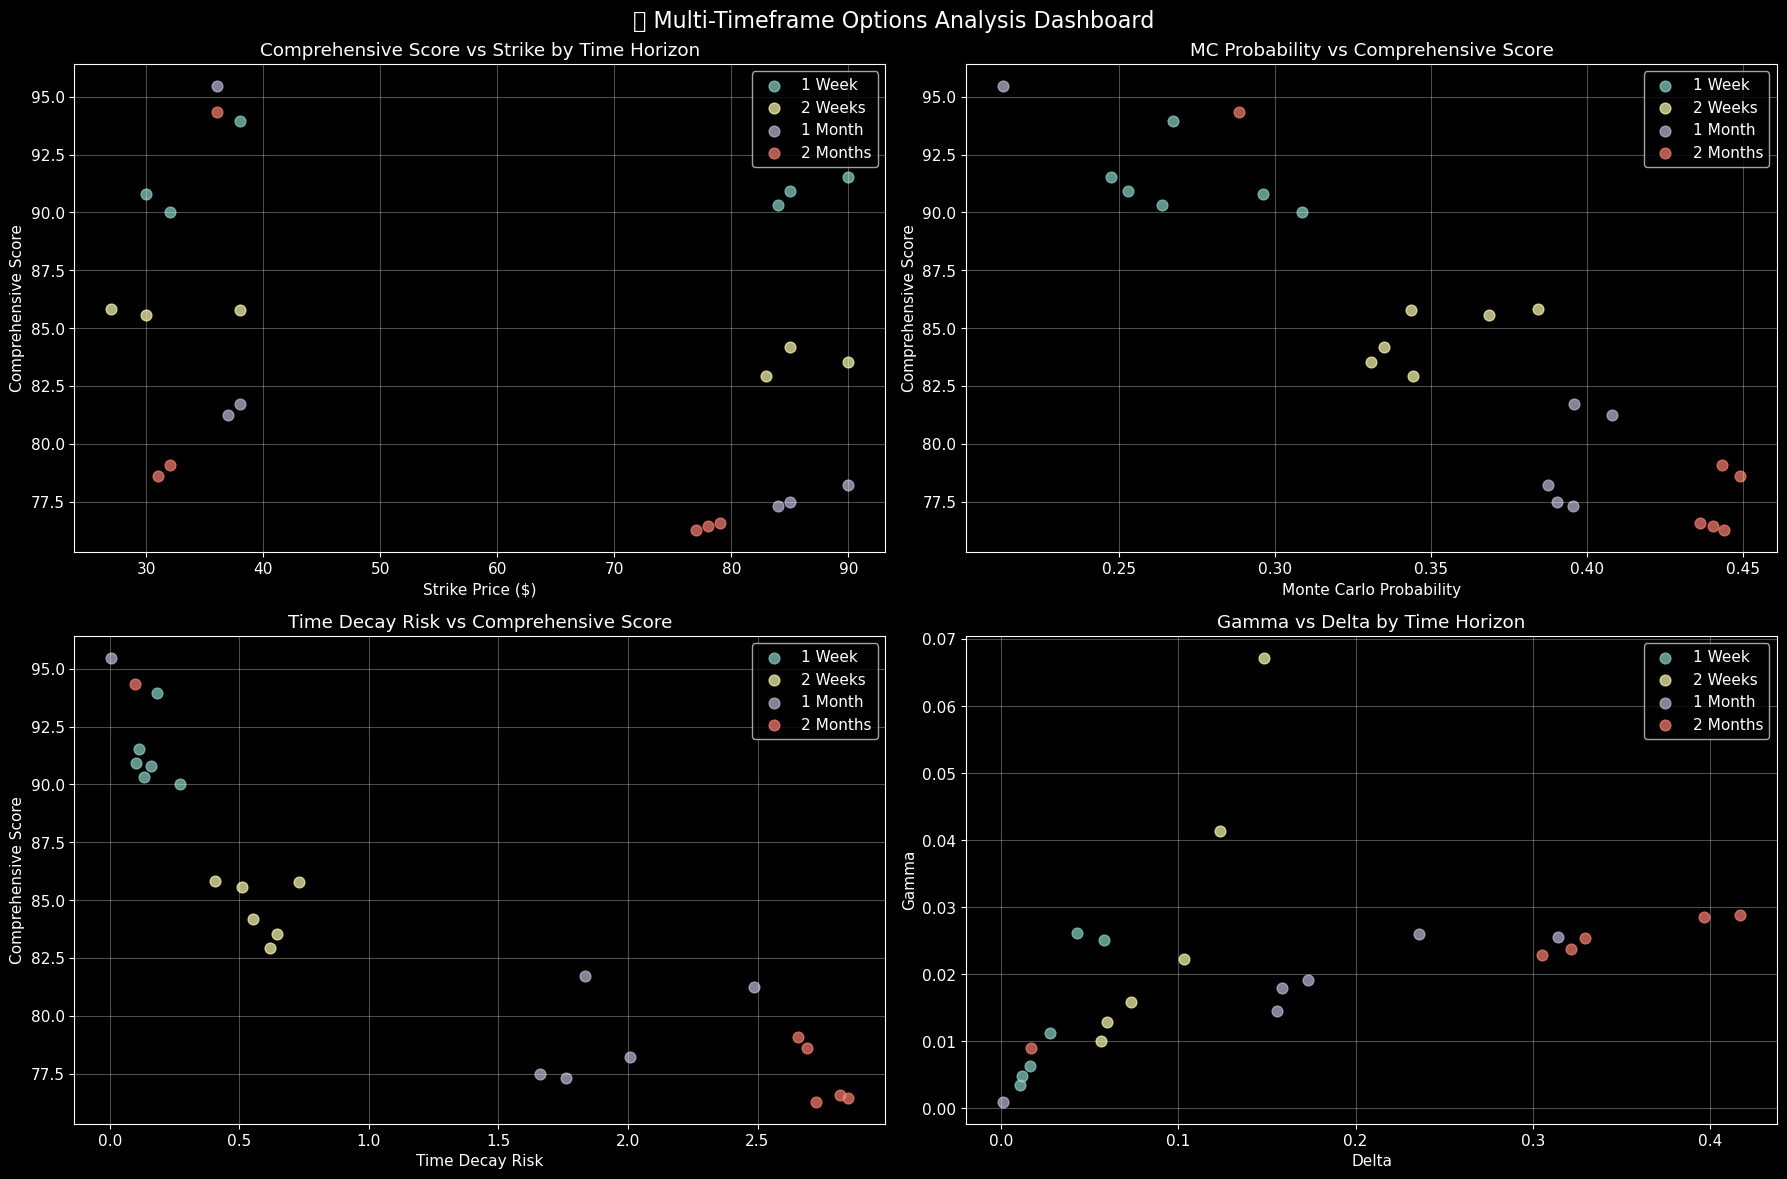

In [ ]:
# Multi-timeframe Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📈 Multi-Timeframe Options Analysis Dashboard', fontsize=16, color='white')

# Create combined data for visualization
combined_data = []
for horizon_name, horizon_results in results_by_horizon.items():
    for ticker, ticker_results in horizon_results.items():
        if len(ticker_results) > 0:
            ticker_results_copy = ticker_results.copy()
            ticker_results_copy['horizon'] = horizon_name
            ticker_results_copy['ticker'] = ticker
            combined_data.append(ticker_results_copy)

if combined_data:
    all_data = pd.concat(combined_data, ignore_index=True)
    
    # Plot 1: Comprehensive Score by Time Horizon
    horizons = list(TIME_HORIZONS.keys())
    for i, horizon in enumerate(horizons):
        horizon_data = all_data[all_data['horizon'] == horizon]
        if len(horizon_data) > 0:
            axes[0, 0].scatter(horizon_data['strike'], horizon_data['comprehensive_score'], 
                             label=f'{horizon}', alpha=0.7, s=60)
    
    axes[0, 0].set_title("Comprehensive Score vs Strike by Time Horizon", color='white')
    axes[0, 0].set_xlabel("Strike Price ($)", color='white')
    axes[0, 0].set_ylabel("Comprehensive Score", color='white')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: MC Probability by Time Horizon
    for i, horizon in enumerate(horizons):
        horizon_data = all_data[all_data['horizon'] == horizon]
        if len(horizon_data) > 0:
            axes[0, 1].scatter(horizon_data['mc_prob'], horizon_data['comprehensive_score'], 
                             label=f'{horizon}', alpha=0.7, s=60)
    
    axes[0, 1].set_title("MC Probability vs Comprehensive Score", color='white')
    axes[0, 1].set_xlabel("Monte Carlo Probability", color='white')
    axes[0, 1].set_ylabel("Comprehensive Score", color='white')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Time Decay Risk by Horizon
    for i, horizon in enumerate(horizons):
        horizon_data = all_data[all_data['horizon'] == horizon]
        if len(horizon_data) > 0:
            axes[1, 0].scatter(horizon_data['time_decay_risk'], horizon_data['comprehensive_score'], 
                             label=f'{horizon}', alpha=0.7, s=60)
    
    axes[1, 0].set_title("Time Decay Risk vs Comprehensive Score", color='white')
    axes[1, 0].set_xlabel("Time Decay Risk", color='white')
    axes[1, 0].set_ylabel("Comprehensive Score", color='white')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Gamma vs Delta by Horizon
    for i, horizon in enumerate(horizons):
        horizon_data = all_data[all_data['horizon'] == horizon]
        if len(horizon_data) > 0:
            axes[1, 1].scatter(horizon_data['delta'], horizon_data['gamma'], 
                             label=f'{horizon}', alpha=0.7, s=60)
    
    axes[1, 1].set_title("Gamma vs Delta by Time Horizon", color='white')
    axes[1, 1].set_xlabel("Delta", color='white')
    axes[1, 1].set_ylabel("Gamma", color='white')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# MULTI-TIMEFRAME TRADING SUMMARY
print("\n" + "="*100)
print("🚀 TOP 3 ASYMMETRIC CRYPTO OPTIONS BY TIME HORIZON 🚀")
print("="*100)

def get_confidence_rating(score):
    if score >= 80:
        return "🟢 STRONG BUY"
    elif score >= 60:
        return "🟡 MODERATE BUY"
    elif score >= 40:
        return "🟠 SPECULATIVE"
    else:
        return "🔴 HIGH RISK"

# Display recommendations for each time horizon
for horizon_name, days in TIME_HORIZONS.items():
    print(f"\n📅 {horizon_name.upper()} ({days} days) RECOMMENDATIONS")
    print("="*80)
    
    for ticker in ETF_TICKERS:
        if len(results_by_horizon[horizon_name][ticker]) > 0:
            print(f"\n💰 {ticker} OPTIONS - Current Price: ${prices[ticker].iloc[-1]:.2f}")
            print("-" * 60)
            
            for i, (_, option) in enumerate(results_by_horizon[horizon_name][ticker].iterrows(), 1):
                confidence = get_confidence_rating(option['comprehensive_score'])
                print(f"#{i} {confidence} | Score: {option['comprehensive_score']:.0f}/100")
                print(f"    📈 Strike: ${option['strike']:.2f} | Cost: ${option['lastPrice']:.2f}")
                
                # Handle expiration date column
                exp_date = ""
                if 'expiration' in option.index:
                    exp_date = f" | Exp: {option['expiration']}"
                elif 'expirationDate' in option.index:
                    exp_date = f" | Exp: {option['expirationDate']}"
                
                print(f"    🎯 Target Return: {option['target_return']:.1f}% | MC Probability: {option['mc_prob']:.1%}{exp_date}")
                print(f"    ⚡ Gamma: {option['gamma']:.3f} | Delta: {option['delta']:.3f}")
                print(f"    ⏰ Time Decay: ${option['time_decay_risk']:.3f}/day | Vol: {option['impliedVolatility']:.1%}")
                print()
        else:
            print(f"\n❌ {ticker} - No options available for {horizon_name}")
        
        print("-" * 60)

# Summary by time horizon
print(f"\n📊 TIMEFRAME ANALYSIS SUMMARY")
print("="*80)
print("🕐 1 Week (7 days):   High gamma, fast moves, high theta risk")
print("🕐 2 Weeks (14 days): Balanced risk-reward, moderate theta")
print("🕐 1 Month (30 days):  Classic options timeframe, good liquidity")
print("🕐 2 Months (60 days): Lower theta, more time for thesis to play out")

print("\n📊 Comprehensive Score Breakdown (1-100):")
print("• Monte Carlo Probability: 40 points max")
print("• Gamma Convexity: 25 points max")
print("• Time Decay Management: 15 points max")
print("• Target Return Potential: 10 points max")
print("• Implied Volatility Boost: 10 points max")
print("\n🎯 Confidence Levels:")
print("• 80-100: 🟢 STRONG BUY - High confidence asymmetric opportunity")
print("• 60-79:  🟡 MODERATE BUY - Good risk-reward potential")
print("• 40-59:  🟠 SPECULATIVE - Higher risk, consider position sizing")
print("• 1-39:   🔴 HIGH RISK - Proceed with extreme caution")
print("=" * 100)

print("\n📊 ANALYSIS COMPLETE - Trade Responsibly! 📊")


🚀 TOP 3 ASYMMETRIC CRYPTO OPTIONS BY TIME HORIZON 🚀

📅 1 WEEK (7 days) RECOMMENDATIONS

💰 IBIT OPTIONS - Current Price: $68.18
------------------------------------------------------------
#1 🟢 STRONG BUY | Score: 92/100
    📈 Strike: $90.00 | Cost: $0.01
    🎯 Target Return: 32.0% | MC Probability: 24.8%
    ⚡ Gamma: 0.003 | Delta: 0.010
    ⏰ Time Decay: $0.111/day | Vol: 84.4%

#2 🟢 STRONG BUY | Score: 91/100
    📈 Strike: $85.00 | Cost: $0.01
    🎯 Target Return: 24.7% | MC Probability: 25.3%
    ⚡ Gamma: 0.005 | Delta: 0.012
    ⏰ Time Decay: $0.102/day | Vol: 68.8%

#3 🟢 STRONG BUY | Score: 90/100
    📈 Strike: $84.00 | Cost: $0.01
    🎯 Target Return: 23.2% | MC Probability: 26.4%
    ⚡ Gamma: 0.006 | Delta: 0.016
    ⏰ Time Decay: $0.133/day | Vol: 68.8%

------------------------------------------------------------

💰 ETHA OPTIONS - Current Price: $22.75
------------------------------------------------------------
#1 🟢 STRONG BUY | Score: 94/100
    📈 Strike: $38.00 | Cost: $0.

## 📈 Greeks Analysis for OTM Calls

### Professional Options Greeks Framework

**Delta (Δ)**: Price Sensitivity Coefficient
- Measures option price change per $1 underlying move
- OTM calls: Lower delta but accelerate as they approach ITM
- **Target**: Delta > 0.10 for meaningful directional exposure

**Gamma (Γ)**: Convexity Accelerator
- **CRITICAL METRIC**: Measures delta acceleration on price moves
- High gamma = exponential upside potential on tail events
- **Target**: Gamma > 0.01 for asymmetric payoff profiles

**Theta (Θ)**: Time Decay Coefficient
- Daily option value erosion rate
- **Risk Factor**: Negative theta creates urgency
- **Target**: Theta < 0.5 per day for manageable decay

**Vega (ν)**: Volatility Sensitivity
- Option price change per 1% volatility shift
- **Critical for Crypto**: High vol environment amplifies vega impact
- **Consideration**: High vega = double-edged sword

### 🎯 Enhanced Scoring Methodology

**Gamma-Adjusted Score**: Monte Carlo probability × convexity leverage
**Convexity Score**: Potential acceleration on large directional moves
**Time Decay Risk**: Total theta exposure over expected holding period

### 🔬 Heavy-Tailed Distribution Analysis

This analysis uses Cauchy distributions to model crypto price movements, incorporating:
- Fat-tailed probability distributions (Mandelbrot's fractal markets)
- Extreme event modeling (black swan scenarios)
- Asymmetric payoff optimization (Taleb's barbell strategy)

**Why This Matters**: Traditional models underestimate tail probabilities in crypto markets. Our heavy-tailed approach better captures the reality of extreme price movements that make OTM calls profitable.

## 🕐 Multi-Timeframe Strategy Framework

### Time Horizon Characteristics

**1 Week (7 days)** - Ultra-Short Term
- **Pros**: High gamma exposure, rapid profit potential, sensitive to momentum
- **Cons**: Extreme theta decay, requires precise timing, high risk
- **Best For**: Earnings plays, catalyst events, short-term breakouts
- **Strategy**: Small position sizes, tight stop-losses, quick exits

**2 Weeks (14 days)** - Short Term  
- **Pros**: Balanced risk-reward, moderate theta, good for swing trades
- **Cons**: Still significant time decay, limited time for thesis development
- **Best For**: Technical breakouts, momentum plays, event-driven trades
- **Strategy**: Active management, position sizing based on conviction

**1 Month (30 days)** - Medium Term
- **Pros**: Classic options timeframe, good liquidity, manageable theta
- **Cons**: Moderate time decay, requires directional conviction
- **Best For**: Trend following, macro themes, earnings cycles
- **Strategy**: Standard position sizing, technical analysis integration

**2 Months (60 days)** - Longer Term
- **Pros**: Lower theta decay, time for thesis to develop, trend following
- **Cons**: Higher premium, capital tie-up, requires patience
- **Best For**: Macro themes, fundamental analysis, trend reversals
- **Strategy**: Larger positions, fundamental analysis, patience required

### 🎯 Portfolio Allocation Strategy

**Recommended Allocation by Time Horizon:**
- 1 Week: 10-15% (high-conviction catalysts only)
- 2 Weeks: 20-25% (momentum and technical plays)
- 1 Month: 35-40% (core directional bets)
- 2 Months: 25-30% (macro themes and trends)

### 📊 Enhanced Analysis Benefits

With **100 million Monte Carlo simulations** per option (100x increase), we achieve:
- **Higher Precision**: More accurate tail probability estimates
- **Better Risk Assessment**: Refined heavy-tailed distribution modeling
- **Improved Confidence**: Reduced simulation noise in scoring
- **Enhanced Reliability**: More robust statistical significance